<a href="https://colab.research.google.com/github/saraMsherbiny/project/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌿 Plant Leaf Dataset Preprocessing

## 📋 Overview

This notebook preprocesses the plant leaf dataset for disease classification. The preprocessing pipeline includes image resizing, augmentation, normalization, and class balancing to prepare the data for deep learning models.

---

## 📊 Dataset Information

### Plant Type Distribution
```
Jamun                 603 images
Pongamia Pinnata      577 images
Pomegranate           538 images
Arjun                 432 images
Mango                 414 images
Alstonia Scholaris    412 images
Gauva                 398 images
Jatropha              237 images
Lemon                 216 images
Chinar                203 images
Basil                 137 images
Bael                  107 images
```

**Total: 4,274 images across 12 plant species**

### Classes
- **Binary Classification**: Healthy vs Diseased
- **Multi-class Classification**: 22 plant-condition combinations

---

## 🔧 Preprocessing Pipeline

### Step 1: Image Size Analysis 📐

Analyzes the original image dimensions to determine optimal resize parameters.

**What this does:**
- Samples 200 random images
- Calculates width, height, and aspect ratio statistics
- Saves results to `metadata/image_stats.json`
- Helps determine the best target image size

---

### Step 2: Process Training Data 🎨

Applies augmentation to increase dataset diversity and prevent overfitting.

**Augmentation Techniques Applied:**

| Transformation | Purpose | Probability |
|---|---|---|
| **Resize to 224×224** | Standardize input size | 100% |
| **Random Rotate 90°** | Learn rotation invariance | 50% |
| **Horizontal Flip** | Mirror images | 50% |
| **Vertical Flip** | Additional orientation | 30% |
| **Shift/Scale/Rotate** | Small geometric variations | 50% |
| **Hue/Saturation/Value** | Color variations (disease symptoms) | 70% |
| **Brightness/Contrast** | Lighting variations | 70% |
| **Gaussian Noise/Blur** | Robustness to image quality | 30% |
| **CoarseDropout** | Regularization technique | 30% |
| **Normalize** | ImageNet mean/std | 100% |

**Why Augmentation?**
- Increases effective dataset size
- Prevents overfitting on small datasets
- Models disease patterns, not image artifacts
- Simulates real-world conditions (lighting, angles, quality)

---

### Step 3: Process Validation Data ✅

Validation data should NOT be augmented to get accurate performance metrics.

**What's Different:**
- Only resize and normalize
- No random transformations
- Ensures consistent evaluation metrics

---

## 📁 Output Structure

After preprocessing:

```
processed_train/
├── train/
│   ├── Jamun_healthy_0.npy
│   ├── Jamun_diseased_1.npy
│   ├── Mango_healthy_2.npy
│   └── ... (4,274 .npy files)
└── metadata/
    ├── processed_data.csv          # Mapping: processed_path → label → plant_type
    ├── plant_encoding.json         # Plant type → numeric label mapping
    ├── class_weights.json          # Weights for handling class imbalance
    └── image_stats.json            # Original image size statistics
```

---

## ⚖️ Handling Class Imbalance

The dataset is imbalanced (Jamun: 603 vs Bael: 107). Class weights are automatically calculated to address this.

**Class Weights Formula:**
```
weight = n_samples / (n_classes × n_samples_for_class)
```

**Purpose:**
- Gives higher weight to underrepresented classes
- Prevents model from always predicting majority class
- Ensures all plant types are learned effectively

---

## 🎯 Recommended Image Sizes

Choose based on your model architecture:

| Model | Recommended Size | Use Case |
|---|---|---|
| **Machine Learning Models** | 224x224 | - |
| **ResNet-18/34/50** | 224×224 | Fast training, good baseline |
| **EfficientNet-B0** | 224×224 | Efficient, state-of-the-art |
| **EfficientNet-B1-B3** | 240×240 - 300×300 | Better accuracy |
| **EfficientNet-B4+** | 380×380+ | Maximum accuracy (slower) |
| **Vision Transformer** | 224×224 or 384×384 | Transformer models |
| **Inception/Xception** | 299×299 | These models expect this size |

**For this dataset:** Start with **224×224** for quick experiments, scale up to **299×299** or **384×384** if you have compute resources.

---

## 🔍 Key Considerations

### Memory Requirements
- Original images: High resolution
- Processed 224×224 .npy files: ~150 KB per image
- .npy files are larger than compressed JPGs but much faster to load during training

### Processing Time
- Analysis only: ~1-2 minutes
- Full preprocessing: ~5-15 minutes depending on dataset size

### Data Split
- Training data: Use augmentation (`apply_transforms=True`)
- Validation data: No augmentation (`apply_transforms=False`)
- Test data: No augmentation (`apply_transforms=False`)

---

## 📈 Workflow Summary

1. **Analyze** → Understand image dimensions and choose target size
2. **Process Training** → Apply augmentation for robust learning
3. **Process Validation** → Keep clean for accurate evaluation
4. **Load Metadata** → Use class weights and encodings in model
5. **Train Model** → Use processed .npy files for fast data loading



[link text](https://)# Download Dataset

In [42]:
# Visualize sample
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing imports
from PIL import Image
import random
import os
import numpy as np
import pandas as pd
from pathlib import Path
import argparse
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import json
# Split  data
from sklearn.model_selection import train_test_split


In [43]:
import kagglehub

# Download latest version if you won't be using kaggle directly
path = kagglehub.dataset_download("csafrit2/plant-leaves-for-image-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plant-leaves-for-image-classification' dataset.
Path to dataset files: /kaggle/input/plant-leaves-for-image-classification


In [44]:
path = '/kaggle/input/plant-leaves-for-image-classification'


In [45]:

modes = ['train','valid']
all_image_paths=[]
all_labels=[]
all_plant_types=[]

for mode in modes:
    base_images_path=os.path.join(path,'Plants_2',mode)
    directory_names=os.listdir(base_images_path)

    for dir_name in directory_names:
        label=''
        plant_type=''

        if 'diseased' in dir_name:
            label='diseased'
            plant_type=dir_name.split(' diseased ')[0].strip()
        elif 'healthy' in dir_name:
            label='healthy'
            plant_type=dir_name.split(' healthy ')[0].strip()
        else:
            if '(P' in dir_name:
                parts=dir_name.split(' (')
                plant_name_and_health=parts[0]
                if 'healthy' in plant_name_and_health:
                    label='healthy'
                    plant_type=plant_name_and_health.replace(' healthy','').strip()
                elif 'diseased' in plant_name_and_health:
                    label='diseased'
                    plant_type=plant_name_and_health.replace(' diseased','').strip()
                else:
                    plant_type=plant_name_and_health.strip()
                    label='unknown'
            else:
                plant_type=dir_name.strip()
                label='unknown'

        current_dir_path=os.path.join(base_images_path,dir_name)

        if os.path.isdir(current_dir_path):
            for img_file in os.listdir(current_dir_path):
                if img_file.lower().endswith(('.png','.jpg','.jpeg')):
                    all_image_paths.append(os.path.join(current_dir_path,img_file))
                    all_labels.append(label)
                    all_plant_types.append(plant_type)

df=pd.DataFrame({
    'image_path':all_image_paths,
    'label':all_labels,
    'plant_type':all_plant_types
})

print(f"Total images combined: {len(df)}")

train_df,valid_df=train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=df['label']
)

train_df.to_csv('train.csv',index=False)
valid_df.to_csv('valid.csv',index=False)

print(f"Train: {len(train_df)} | Valid: {len(valid_df)}")
print("Sample from training set:")
train_df.head()

Total images combined: 4384
Train: 3507 | Valid: 877
Sample from training set:


,image_path,label,plant_type
3955,/kaggle/input/plant-leaves-for-image-classific...,diseased,Chinar
499,/kaggle/input/plant-leaves-for-image-classific...,healthy,Gauva
223,/kaggle/input/plant-leaves-for-image-classific...,healthy,Alstonia Scholaris
671,/kaggle/input/plant-leaves-for-image-classific...,diseased,Gauva
2654,/kaggle/input/plant-leaves-for-image-classific...,diseased,Arjun


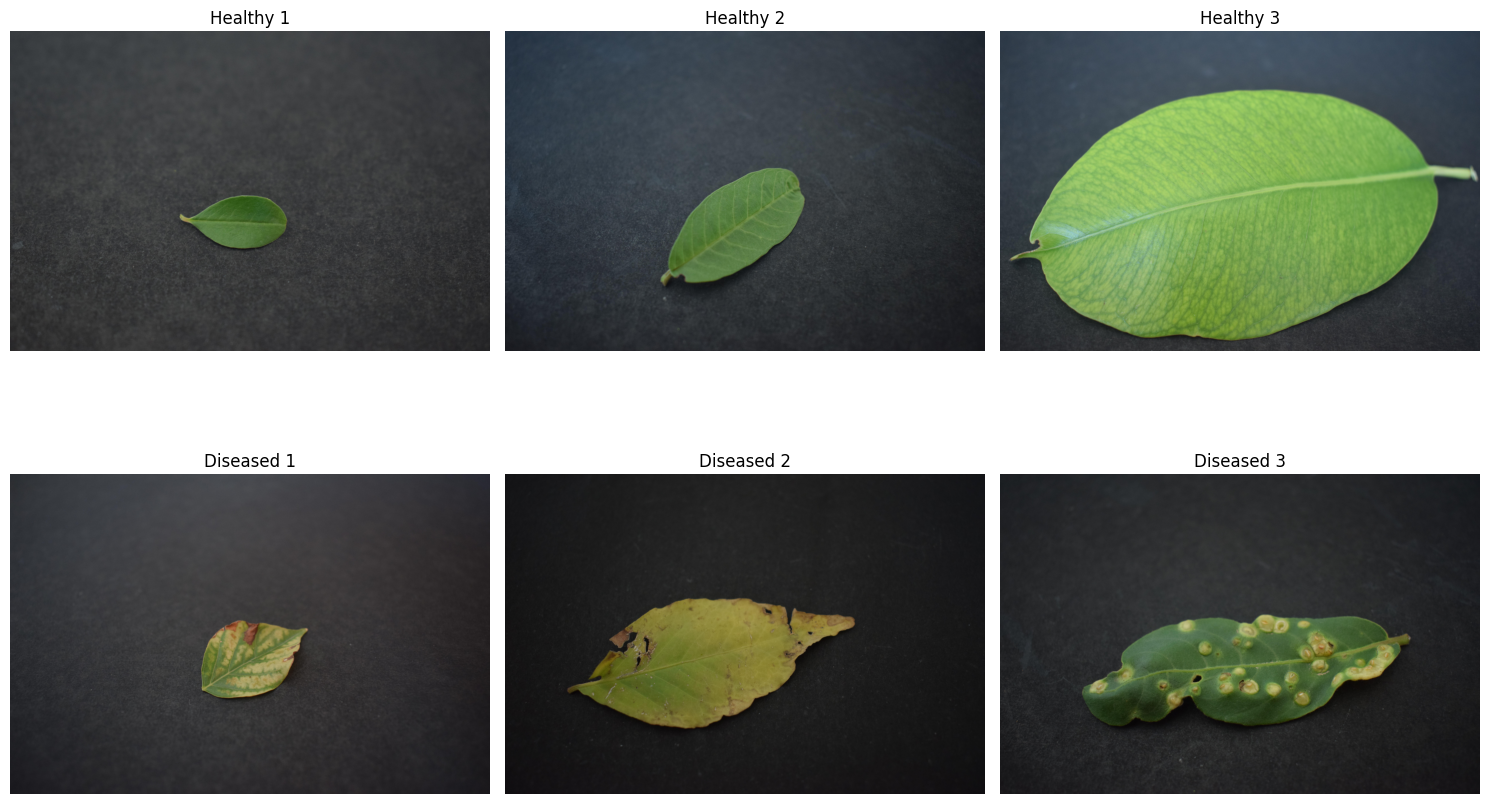

In [46]:
healthy_samples = train_df[train_df['label'] == 'healthy']['image_path'].sample(3, random_state=42) # Select 3 random healthy samples
diseased_samples = train_df[train_df['label'] == 'diseased']['image_path'].sample(3, random_state=42) # Select 3 random diseased samples

plt.figure(figsize=(15, 10))

# Plot healthy samples
for i, img_path in enumerate(healthy_samples):
    plt.subplot(2, 3, i + 1) # 2 rows, 3 columns
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Healthy {i+1}")
    plt.axis('off')

# Plot diseased samples
for i, img_path in enumerate(diseased_samples):
    plt.subplot(2, 3, i + 4) # 2 rows, 3 columns, starting from second row
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Diseased {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# 🕵🏻‍♂️ Investigate Dataset:

In [47]:
# Classes distribution
train_df['plant_type'].value_counts()

,count
plant_type,
Jamun,492
Pongamia Pinnata,481
Pomegranate,440
Arjun,362
Alstonia Scholaris,348
Mango,342
Gauva,319
Jatropha,191
Lemon,175


In [48]:
train_df['label'].value_counts()

,count
label,
healthy,1774
diseased,1733


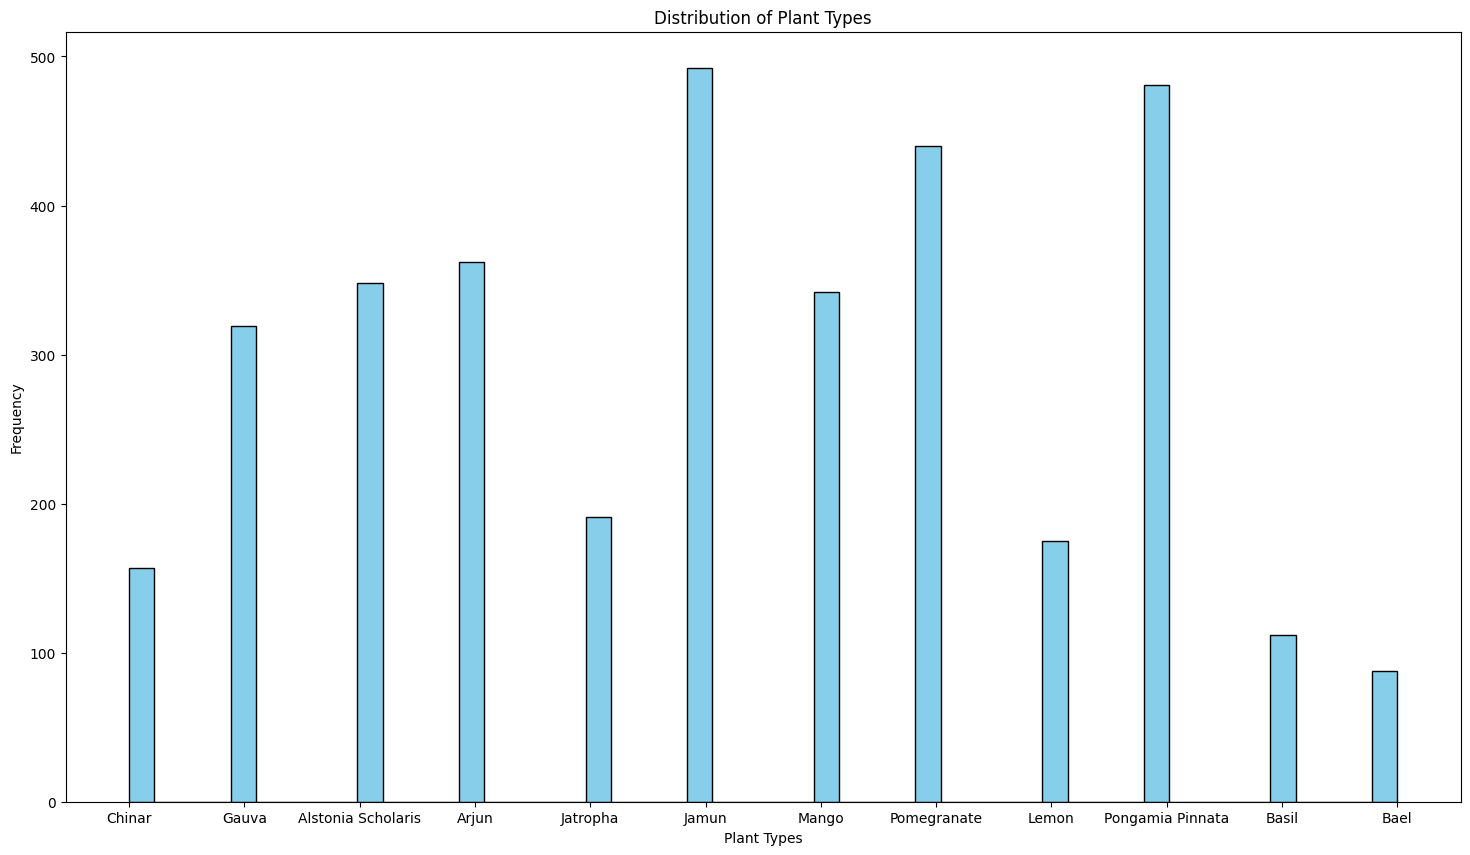

In [49]:
plt.figure(figsize=(18, 10))
plt.hist(train_df['plant_type'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Plant Types')
plt.xlabel('Plant Types')
plt.ylabel('Frequency')
plt.show()

In [50]:
# Open the image using PIL
img = Image.open(df['image_path'][1])

# Get the size (width, height) of the image
image_resolution = img.size
print(f"Resolution of the image: {image_resolution}")

Resolution of the image: (6000, 4000)


- Image has high resolution

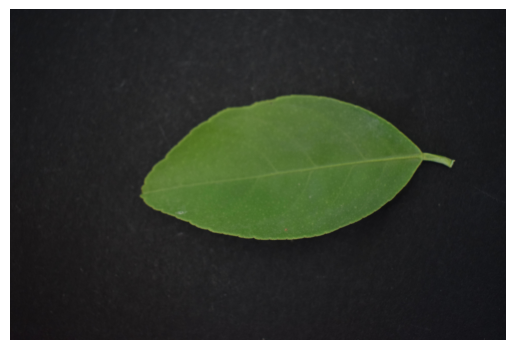

In [51]:
# One image will be tested first
sample_path = train_df['image_path'][1]
img = Image.open(sample_path)
plt.imshow(img)
plt.axis('off')
plt.show()


In [52]:
class PlantLeafPreprocessor:
    def __init__(self, csv_path, output_dir, img_size=224, apply_transforms=True):
        """
        Initialize the preprocessor

        Args:
            csv_path: Path to the CSV file with image_path, label, plant_type columns
            output_dir: Directory to save preprocessed images
            img_size: Target size for images (default: 224 for most CNNs)
            apply_transforms: Whether to apply augmentation transforms
        """
        self.csv_path = csv_path
        self.output_dir = Path(output_dir)
        self.img_size = img_size
        self.apply_transforms = apply_transforms

        # Create output directories
        self.output_dir.mkdir(parents=True, exist_ok=True)
        (self.output_dir / 'train').mkdir(exist_ok=True)
        (self.output_dir / 'metadata').mkdir(exist_ok=True)

        # Load data
        self.df = pd.read_csv(csv_path)
        print(f"Loaded {len(self.df)} images")
        print(f"\nDataset distribution:")
        print(self.df['plant_type'].value_counts())
        print(f"\nLabel distribution:")
        print(self.df['label'].value_counts())

    def get_basic_transform(self):
        """Basic preprocessing without augmentation"""
        return A.Compose([
            A.Resize(self.img_size, self.img_size),
            A.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225]),
        ])

    def get_augmentation_transform(self):
        """Augmentation pipeline for training data"""
        return A.Compose([
            # Resize
            A.Resize(self.img_size, self.img_size),

            # Geometric transforms
            A.RandomRotate90(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.3),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15,
                              rotate_limit=45, p=0.5),

            # Color transforms (important for leaf diseases)
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=20,
                                    sat_shift_limit=30,
                                    val_shift_limit=20, p=1.0),
                A.RandomBrightnessContrast(brightness_limit=0.2,
                                          contrast_limit=0.2, p=1.0),
                A.ColorJitter(brightness=0.2, contrast=0.2,
                            saturation=0.2, hue=0.1, p=1.0),
            ], p=0.7),

            # Noise and blur
            # A.OneOf([
            #     A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
            #     A.GaussianBlur(blur_limit=(3, 7), p=1.0),
            #     A.MotionBlur(blur_limit=5, p=1.0),
            # ], p=0.3),

            # Cutout/CoarseDropout for regularization
            A.CoarseDropout(max_holes=8, max_height=16, max_width=16,
                           fill_value=0, p=0.3),

            # Normalize
            A.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225]),
        ])

    def analyze_image_sizes(self):
        """Analyze the distribution of image sizes in the dataset"""
        print("\nAnalyzing image sizes...")
        widths, heights, aspects = [], [], []

        sample_size = min(200, len(self.df))
        sample_indices = np.random.choice(len(self.df), sample_size, replace=False)

        for idx in tqdm(sample_indices, desc="Sampling images"):
            img_path = self.df.iloc[idx]['image_path']
            try:
                with Image.open(img_path) as img:
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
                    aspects.append(w/h)
            except Exception as e:
                print(f"Error reading {img_path}: {e}")

        stats = {
            'width': {'min': min(widths), 'max': max(widths),
                     'mean': np.mean(widths), 'median': np.median(widths)},
            'height': {'min': min(heights), 'max': max(heights),
                      'mean': np.mean(heights), 'median': np.median(heights)},
            'aspect_ratio': {'min': min(aspects), 'max': max(aspects),
                           'mean': np.mean(aspects), 'median': np.median(aspects)}
        }

        print("\nImage Size Statistics:")
        print(f"Width  - Min: {stats['width']['min']}, Max: {stats['width']['max']}, "
              f"Mean: {stats['width']['mean']:.1f}, Median: {stats['width']['median']:.1f}")
        print(f"Height - Min: {stats['height']['min']}, Max: {stats['height']['max']}, "
              f"Mean: {stats['height']['mean']:.1f}, Median: {stats['height']['median']:.1f}")
        print(f"Aspect Ratio - Min: {stats['aspect_ratio']['min']:.2f}, "
              f"Max: {stats['aspect_ratio']['max']:.2f}, Mean: {stats['aspect_ratio']['mean']:.2f}")

        # Save stats
        with open(self.output_dir / 'metadata' / 'image_stats.json', 'w') as f:
            json.dump(stats, f, indent=2)

        return stats

    def preprocess_dataset(self, save_images=True):
        """
        Preprocess the entire dataset

        Args:
            save_images: If True, saves preprocessed images. If False, only validates.
        """
        transform = self.get_augmentation_transform() if self.apply_transforms else self.get_basic_transform()

        failed_images = []
        processed_data = []

        for idx, row in tqdm(self.df.iterrows(), total=len(self.df), desc="Processing images"):
            img_path = row['image_path']
            label = row['label']
            plant_type = row['plant_type']

            try:
                # Read image
                image = cv2.imread(img_path)
                if image is None:
                    raise ValueError(f"Failed to read image: {img_path}")

                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Apply transforms
                transformed = transform(image=image)
                transformed_image = transformed['image']

                if save_images:
                    # Create output filename
                    plant_clean = plant_type.replace(' ', '_')
                    output_filename = f"{plant_clean}_{label}_{idx}.npy"
                    output_path = self.output_dir / 'train' / output_filename

                    # Save as numpy array (more efficient for ML pipelines)
                    np.save(output_path, transformed_image)

                    processed_data.append({
                        'original_path': img_path,
                        'processed_path': str(output_path),
                        'label': label,
                        'plant_type': plant_type,
                        'label_encoded': 1 if label == 'diseased' else 0
                    })

            except Exception as e:
                print(f"\nError processing {img_path}: {e}")
                failed_images.append({'path': img_path, 'error': str(e)})

        # Save processed metadata
        if save_images and processed_data:
            processed_df = pd.DataFrame(processed_data)
            processed_df.to_csv(self.output_dir / 'metadata' / 'processed_data.csv', index=False)

            # Create label encodings
            plant_types = sorted(processed_df['plant_type'].unique())
            plant_encoding = {plant: idx for idx, plant in enumerate(plant_types)}

            with open(self.output_dir / 'metadata' / 'plant_encoding.json', 'w') as f:
                json.dump(plant_encoding, f, indent=2)

            print(f"\n✓ Successfully processed {len(processed_data)} images")
            print(f"✓ Saved to: {self.output_dir / 'train'}")
            print(f"✓ Metadata saved to: {self.output_dir / 'metadata'}")

        if failed_images:
            print(f"\n✗ Failed to process {len(failed_images)} images")
            failed_df = pd.DataFrame(failed_images)
            failed_df.to_csv(self.output_dir / 'metadata' / 'failed_images.csv', index=False)

    def create_class_weights(self):
        """Calculate class weights for imbalanced dataset"""
        from sklearn.utils.class_weight import compute_class_weight

        # For binary classification (healthy vs diseased)
        labels = (self.df['label'] == 'diseased').astype(int).values
        class_weights = compute_class_weight('balanced',
                                            classes=np.unique(labels),
                                            y=labels)

        # For multi-class (plant type)
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        plant_labels = le.fit_transform(self.df['plant_type'])
        plant_weights = compute_class_weight('balanced',
                                            classes=np.unique(plant_labels),
                                            y=plant_labels)

        weights_info = {
            'binary_class_weights': {
                'healthy': float(class_weights[0]),
                'diseased': float(class_weights[1])
            },
            'plant_type_weights': {
                plant: float(weight)
                for plant, weight in zip(le.classes_, plant_weights)
            }
        }

        with open(self.output_dir / 'metadata' / 'class_weights.json', 'w') as f:
            json.dump(weights_info, f, indent=2)

        print("\nClass Weights:")
        print(f"Binary (healthy/diseased): {weights_info['binary_class_weights']}")
        print(f"\nSaved class weights to metadata/class_weights.json")

        return weights_info


def main():
    parser = argparse.ArgumentParser(description='Preprocess plant leaf dataset')
    parser.add_argument('--csv_path', type=str, required=True,
                       help='Path to CSV file with image_path, label, plant_type')
    parser.add_argument('--output_dir', type=str, required=True,
                       help='Output directory for preprocessed data')
    parser.add_argument('--img_size', type=int, default=224,
                       help='Target image size (default: 224)')
    parser.add_argument('--apply_transforms', action='store_true',
                       help='Apply augmentation transforms')
    parser.add_argument('--analyze_only', action='store_true',
                       help='Only analyze image sizes without preprocessing')
    parser.add_argument('--no_save', action='store_true',
                       help='Validate pipeline without saving images')

    args = parser.parse_args()

    print("="*60)
    print("Plant Leaf Dataset Preprocessor")
    print("="*60)
    print(f"CSV Path: {args.csv_path}")
    print(f"Output Directory: {args.output_dir}")
    print(f"Image Size: {args.img_size}x{args.img_size}")
    print(f"Apply Augmentation: {args.apply_transforms}")
    print("="*60)

    preprocessor = PlantLeafPreprocessor(
        csv_path=args.csv_path,
        output_dir=args.output_dir,
        img_size=args.img_size,
        apply_transforms=args.apply_transforms
    )

    # Analyze image sizes
    preprocessor.analyze_image_sizes()

    if not args.analyze_only:
        # Calculate class weights
        preprocessor.create_class_weights()

        # Preprocess dataset
        preprocessor.preprocess_dataset(save_images=not args.no_save)

    print("\n" + "="*60)
    print("Preprocessing complete!")
    print("="*60)


# Notebook-friendly function
def run_preprocessing(csv_path, output_dir, img_size=224, apply_transforms=True,
                     analyze_only=False, save_images=True):
    """
    Run preprocessing directly from notebook

    Example usage:
        run_preprocessing(
            csv_path='train.csv',
            output_dir='./processed_data',
            img_size=224,
            apply_transforms=True
        )
    """
    print("="*60)
    print("Plant Leaf Dataset Preprocessor")
    print("="*60)
    print(f"CSV Path: {csv_path}")
    print(f"Output Directory: {output_dir}")
    print(f"Image Size: {img_size}x{img_size}")
    print(f"Apply Augmentation: {apply_transforms}")
    print("="*60)

    preprocessor = PlantLeafPreprocessor(
        csv_path=csv_path,
        output_dir=output_dir,
        img_size=img_size,
        apply_transforms=apply_transforms
    )

    # Analyze image sizes
    preprocessor.analyze_image_sizes()

    if not analyze_only:
        # Calculate class weights
        preprocessor.create_class_weights()

        # Preprocess dataset
        preprocessor.preprocess_dataset(save_images=save_images)

    print("\n" + "="*60)
    print("Preprocessing complete!")
    print("="*60)

    return preprocessor


In [53]:
csv_path = '/kaggle/working/train.csv'

In [54]:
# Step 1: Analyze first
run_preprocessing(
    csv_path='train.csv',
    output_dir='/kaggle/working/analysis',
    analyze_only=True
)

Plant Leaf Dataset Preprocessor
CSV Path: train.csv
Output Directory: /kaggle/working/analysis
Image Size: 224x224
Apply Augmentation: True
Loaded 3507 images

Dataset distribution:
plant_type
Jamun                 492
Pongamia Pinnata      481
Pomegranate           440
Arjun                 362
Alstonia Scholaris    348
Mango                 342
Gauva                 319
Jatropha              191
Lemon                 175
Chinar                157
Basil                 112
Bael                   88
Name: count, dtype: int64

Label distribution:
label
healthy     1774
diseased    1733
Name: count, dtype: int64

Analyzing image sizes...


Sampling images: 100%|██████████| 200/200 [00:01<00:00, 118.43it/s]


Image Size Statistics:
Width  - Min: 6000, Max: 6000, Mean: 6000.0, Median: 6000.0
Height - Min: 4000, Max: 4000, Mean: 4000.0, Median: 4000.0
Aspect Ratio - Min: 1.50, Max: 1.50, Mean: 1.50

Preprocessing complete!


In [55]:
# Step 2: Process training data (with augmentation)
run_preprocessing(
    csv_path='train.csv',
    output_dir='./processed_train',
    img_size=224,
    apply_transforms=True  # Adds augmentation
)

Plant Leaf Dataset Preprocessor
CSV Path: train.csv
Output Directory: ./processed_train
Image Size: 224x224
Apply Augmentation: True
Loaded 3507 images

Dataset distribution:
plant_type
Jamun                 492
Pongamia Pinnata      481
Pomegranate           440
Arjun                 362
Alstonia Scholaris    348
Mango                 342
Gauva                 319
Jatropha              191
Lemon                 175
Chinar                157
Basil                 112
Bael                   88
Name: count, dtype: int64

Label distribution:
label
healthy     1774
diseased    1733
Name: count, dtype: int64

Analyzing image sizes...


Sampling images: 100%|██████████| 200/200 [00:01<00:00, 185.99it/s]
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3146694237.py:70: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16,



Image Size Statistics:
Width  - Min: 6000, Max: 6000, Mean: 6000.0, Median: 6000.0
Height - Min: 4000, Max: 4000, Mean: 4000.0, Median: 4000.0
Aspect Ratio - Min: 1.50, Max: 1.50, Mean: 1.50

Class Weights:
Binary (healthy/diseased): {'healthy': 0.9884441939120632, 'diseased': 1.0118291979226774}

Saved class weights to metadata/class_weights.json


Processing images: 100%|██████████| 3507/3507 [13:34<00:00,  4.31it/s]


✓ Successfully processed 3507 images
✓ Saved to: processed_train/train
✓ Metadata saved to: processed_train/metadata

Preprocessing complete!


In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
# Step 3: Process validation data (no augmentation)
run_preprocessing(
    csv_path='valid.csv',
    output_dir='./processed_val',
    img_size=224,
    apply_transforms=False  # No augmentation for validation
)

Plant Leaf Dataset Preprocessor
CSV Path: valid.csv
Output Directory: ./processed_val
Image Size: 224x224
Apply Augmentation: False
Loaded 877 images

Dataset distribution:
plant_type
Jamun                 121
Pomegranate           108
Pongamia Pinnata      106
Gauva                  89
Mango                  82
Arjun                  80
Alstonia Scholaris     74
Chinar                 56
Jatropha               56
Lemon                  51
Basil                  30
Bael                   24
Name: count, dtype: int64

Label distribution:
label
healthy     444
diseased    433
Name: count, dtype: int64

Analyzing image sizes...


Sampling images: 100%|██████████| 200/200 [00:01<00:00, 117.49it/s]



Image Size Statistics:
Width  - Min: 6000, Max: 6000, Mean: 6000.0, Median: 6000.0
Height - Min: 4000, Max: 4000, Mean: 4000.0, Median: 4000.0
Aspect Ratio - Min: 1.50, Max: 1.50, Mean: 1.50

Class Weights:
Binary (healthy/diseased): {'healthy': 0.9876126126126126, 'diseased': 1.01270207852194}

Saved class weights to metadata/class_weights.json


Processing images: 100%|██████████| 877/877 [03:24<00:00,  4.29it/s]


✓ Successfully processed 877 images
✓ Saved to: processed_val/train
✓ Metadata saved to: processed_val/metadata

Preprocessing complete!



===== Decision Tree Results =====
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       444
           1       0.58      0.57      0.57       433

    accuracy                           0.58       877
   macro avg       0.58      0.58      0.58       877
weighted avg       0.58      0.58      0.58       877

Confusion Matrix:
 [[265 179]
 [188 245]]


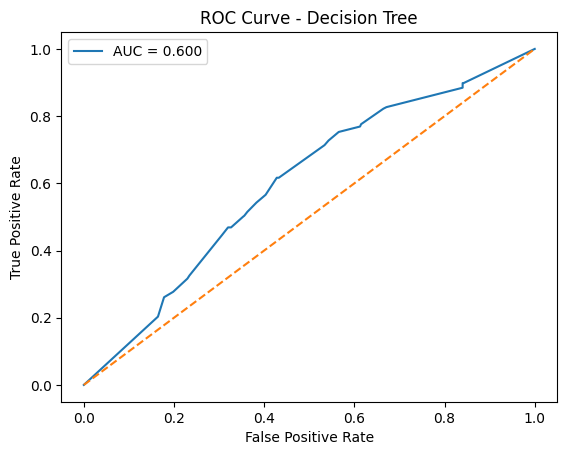

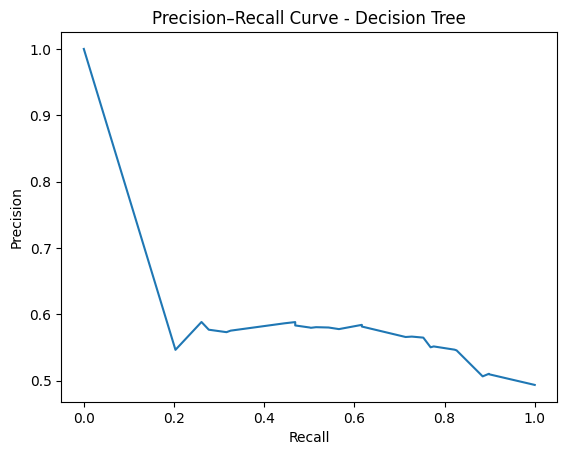

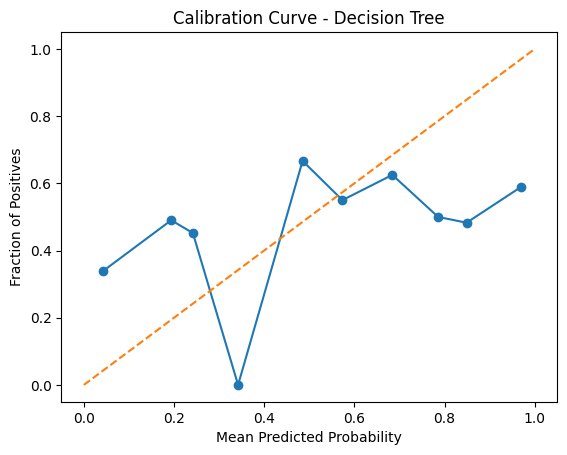

Misclassified samples: 367


,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Decision Tree,0.581528,0.57783,0.56582,0.571762,0.599983


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve,
    precision_recall_curve
)
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler


# ===================== PATHS  =====================

TRAIN_META = "./processed_train/metadata/processed_data.csv"
VAL_META   = "./processed_val/metadata/processed_data.csv"


# ===================== LOAD DATA =====================

train_df = pd.read_csv(TRAIN_META)
val_df   = pd.read_csv(VAL_META)

def load_npy_data(df):
    X, y = [], []
    for _, row in df.iterrows():
        img = np.load(row["processed_path"])   # (224,224,3)
        X.append(img.flatten())                 # flatten for DT
        y.append(row["label_encoded"])
    return np.array(X), np.array(y)

X_train, y_train = load_npy_data(train_df)
X_test,  y_test  = load_npy_data(val_df)


# ===================== SCALING =====================

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


# ===================== DECISION TREE MODEL =====================

model = DecisionTreeClassifier(
    max_depth=10,
    random_state=42
)

model.fit(X_train, y_train)


# ===================== PREDICTIONS =====================

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


# ===================== METRICS =====================

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\n===== Decision Tree Results =====")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


# ===================== ROC CURVE =====================

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.show()


# ===================== PRECISION-RECALL CURVE =====================

precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve - Decision Tree")
plt.show()


# ===================== CALIBRATION CURVE =====================

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
plt.figure()
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1], [0,1], "--")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve - Decision Tree")
plt.show()


# ===================== MISCLASSIFICATION ANALYSIS =====================

mis_idx = np.where(y_test != y_pred)[0]
print("Misclassified samples:", len(mis_idx))


# ===================== SAVE METRICS =====================

metrics_df = pd.DataFrame([{
    "Model": "Decision Tree",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-score": f1,
    "ROC-AUC": auc
}])

metrics_df.to_csv("decision_tree_metrics.csv", index=False)
metrics_df
